# Проект "Определение перспективного тарифа для телеком-компании"

**Описание проекта**

Я аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Мне предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В моем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

Тариф «Смарт»:

Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»:

Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

*Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*


## Изучение данных из файлов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

calls = pd.read_csv('/datasets/calls.csv', parse_dates = ['call_date'])
users = pd.read_csv('/datasets/users.csv', parse_dates = ['reg_date', 'churn_date'])
tariffs = pd.read_csv('/datasets/tariffs.csv')
messages = pd.read_csv('/datasets/messages.csv', parse_dates = ['message_date'])
internet = pd.read_csv('/datasets/internet.csv', parse_dates = ['session_date'], index_col=0)

У нас 5 файлов, изучим их:

In [2]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Пропущенные значения в данных отсутствуют.

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, - то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

В столбце churn_date обнаружены пропущеные значения, это значит, что на момент выгрузки тариф еще действовал, поэтому оставим эти пропуски без изменений 

In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Пропущенные значения в данных отсутствуют.

In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Пропущенные значения в данных отсутствуют.

In [6]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Пропущенные значения в данных отсутствуют.

### Вывод

В целом данные выглядят корректно, пропущенные значения отсутствуют (там, где пропущены, оставляем без изменений), типы данных соответствуют содержанию.

## Предобработка данных

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [7]:
# Извлечем месяц в отдельный столбец из столбца с датой в таблице calls:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d %H:%M')
calls['month'] = calls['call_date'].dt.month
calls

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


In [8]:
# Извлечем месяц в отдельный столбец из столбца с датой в таблице messages:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d %H:%M')
messages['month'] = messages['message_date'].dt.month
messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


In [9]:
# Извлечем месяц в отдельный столбец из столбца с датой в таблице internet:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d %H:%M')
internet['month'] = internet['session_date'].dt.month
internet

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,10
149392,1499_153,490.13,2018-12-14,1499,12
149393,1499_154,0.00,2018-10-27,1499,10
149394,1499_155,1246.32,2018-11-26,1499,11


In [10]:
calls['duration'].value_counts()

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64

In [11]:
internet['mb_used'].value_counts()

0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
          ...  
72.49         1
846.22        1
429.17        1
899.03        1
483.87        1
Name: mb_used, Length: 70003, dtype: int64

Скорее всего нули в звонках обусловлены пропущенными звонками, а в интернет-сессиях - ошибочными сессиями. На данном этапе мы ничего не будем с ними делать, тк они все равно схлопнутся при последующих группировках таблиц.

In [12]:
# Округляем секунды до минут согласно тарифам:
calls['duration'] = calls['duration'].apply(np.ceil)

#Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам:
calls = calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index()
calls

,user_id,month,duration
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0
3,1000,8,408.0
4,1000,9,466.0
...,...,...,...
3169,1498,10,247.0
3170,1499,9,70.0
3171,1499,10,449.0
3172,1499,11,612.0


In [13]:
#Посчитаем для каждого пользователя количество отправленных сообщений по месяцам:
messages = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).reset_index()

messages

,user_id,month,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [14]:
#Посчитаем для каждого пользователя объем израсходованного интернет-трафика по месяцам:
internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
internet

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


In [15]:
#Для удобства расчетов, объединим таблицы calls, messages, internet по user_id и month методом merge:
data = calls.merge(messages, on = ['user_id', 'month'], how = 'outer')
data = data.merge(internet, on = ['user_id', 'month'], how = 'outer')
data

,user_id,month,duration,id,mb_used
0,1000,5,159.0,22.0,2253.49
1,1000,6,172.0,60.0,23233.77
2,1000,7,340.0,75.0,14003.64
3,1000,8,408.0,81.0,14055.93
4,1000,9,466.0,57.0,14568.91
...,...,...,...,...,...
3209,1489,9,NaN,32.0,17206.30
3210,1489,10,NaN,21.0,19559.44
3211,1489,11,NaN,20.0,17491.56
3212,1489,12,NaN,35.0,17322.51


In [16]:
#Присоединим таблицу users:
data = data.merge(users, on = ['user_id'], how = 'left')
data

,user_id,month,duration,id,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,32.0,17206.30,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3210,1489,10,NaN,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3211,1489,11,NaN,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3212,1489,12,NaN,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart


In [17]:
#Присоединим таблицу tariffs:
data = data.merge(tariffs, left_on = 'tariff', right_on = 'tariff_name', how = 'left')
data

,user_id,month,duration,id,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,NaN,32.0,17206.30,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3210,1489,10,NaN,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3211,1489,11,NaN,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3212,1489,12,NaN,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,smart


In [18]:
#Проверим на пропуски объедененную таблицу:
data.isna().sum()

user_id                     0
month                       0
duration                   40
id                        497
mb_used                    11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
tariff_name                 0
dtype: int64

Появились пропуски в столбцах: duration, id, mb_used, churn_date. Churn_date по-прежнему оставляем без изменений, тк это действующие контракты. Пропуски в month, duration, id, mb_used появились в следствии того, что некоторые пользователи в какие-то месяцы не пользовались теми или иными услугами. Заполним их нулями.

In [19]:
#Заполним пропуски нулями методом .fillna(), тк пропущенные значения имеют значения NaN:
data['duration'] = data['duration'].fillna(0)
data['id'] = data['id'].fillna(0)
data['mb_used'] = data['mb_used'].fillna(0)

data.isna().sum()

user_id                     0
month                       0
duration                    0
id                          0
mb_used                     0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
tariff_name                 0
dtype: int64

Посчитаем помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [20]:
# Посчитаем сумму, уплаченную абонентами за сверхлимитные звонки:

# Вычтем бесплатный лимит из суммарного количества звонков:
data['duration_superlimit'] = (data['duration'] - data['minutes_included']) 

# Уберем отрицательные значения:
data.loc[data['duration_superlimit'] < 0, 'duration_superlimit'] = 0

# Остаток умножаем на значение из тарифного плана:
data['duration_superlimit'] = data['duration_superlimit'] * data['rub_per_minute']

data.sort_values(by='duration_superlimit')

,user_id,month,duration,id,mb_used,age,churn_date,city,first_name,last_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,duration_superlimit
0,1000,5,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,1000,30720,3000,1950,150,1,1,ultra,0.0
2014,1321,11,450.0,30.0,19204.52,29,NaT,Москва,Онисим,Софронов,...,smart,50,15360,500,550,200,3,3,smart,0.0
2015,1321,12,340.0,19.0,17537.95,29,NaT,Москва,Онисим,Софронов,...,smart,50,15360,500,550,200,3,3,smart,0.0
2016,1322,9,342.0,0.0,12673.62,45,NaT,Балашиха,Александр,Сальников,...,smart,50,15360,500,550,200,3,3,smart,0.0
2020,1323,8,481.0,59.0,16995.94,67,NaT,Челябинск,Эсмеральда,Носкова,...,smart,50,15360,500,550,200,3,3,smart,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,1486,12,1007.0,83.0,38552.45,35,NaT,Нижний Новгород,Матвей,Моргунов,...,smart,50,15360,500,550,200,3,3,smart,1521.0
1452,1229,12,1022.0,6.0,24999.56,24,NaT,Москва,Нелли,Зубкова,...,smart,50,15360,500,550,200,3,3,smart,1566.0
1622,1261,12,1074.0,22.0,32650.91,46,NaT,Казань,Мадина,Пантелеева,...,smart,50,15360,500,550,200,3,3,smart,1722.0
2855,1451,12,1144.0,50.0,16951.64,58,NaT,Набережные Челны,Виктория,Завьялова,...,smart,50,15360,500,550,200,3,3,smart,1932.0


In [21]:
# Посчитаем сумму, уплаченную абонентами за сверхлимитные смс:

# Вычтем бесплатный лимит из суммарного количества смс:
data['id_superlimit'] = (data['id'] - data['messages_included']) 

# Уберем отрицательные значения:
data.loc[data['id_superlimit'] < 0, 'id_superlimit'] = 0

# Остаток умножаем на значение из тарифного плана:
data['id_superlimit'] = data['id_superlimit'] * data['rub_per_message']

data['id_superlimit'].value_counts()


0.0      2650
3.0        24
48.0       20
18.0       20
30.0       19
         ... 
195.0       1
222.0       1
186.0       1
237.0       1
213.0       1
Name: id_superlimit, Length: 74, dtype: int64

In [22]:
# Посчитаем сумму, уплаченную абонентами за сверхлимитный интернет-трафик:

# Вычтем бесплатный лимит из суммарного количества интернет-трафика:
data['mb_used_superlimit'] = (data['mb_used'] - data['mb_per_month_included']) 

# Уберем отрицательные значения:
data.loc[data['mb_used_superlimit'] < 0, 'mb_used_superlimit'] = 0

# Переводим мегабайты в гигабайты, тк дополнительный интернет-трафик учитывается в гигабайтах: 
data['gb_used_superlimit'] = data['mb_used_superlimit'] / 1024

# Округляем мегабайты до гигабайт согласно тарифам: 
data['gb_used_superlimit'] = data['gb_used_superlimit'].apply(np.ceil)

# Остаток умножаем на значение из тарифного плана:
data['gb_used_superlimit'] = data['gb_used_superlimit'] * data['rub_per_gb']

data['gb_used_superlimit'].value_counts()

0.0       1776
400.0      183
200.0      174
600.0      163
800.0      155
1000.0     140
1200.0     124
1400.0     114
1600.0      72
1800.0      59
2000.0      53
2200.0      28
2400.0      22
300.0       21
450.0       18
2600.0      18
150.0       12
1050.0      10
750.0       10
1350.0       9
3200.0       7
2800.0       7
900.0        7
1950.0       6
3000.0       5
1500.0       4
3400.0       3
4000.0       3
4200.0       2
1650.0       2
3800.0       1
2250.0       1
2850.0       1
2100.0       1
4600.0       1
4400.0       1
2700.0       1
Name: gb_used_superlimit, dtype: int64

In [23]:
#Посчитаем ежемесячную выручку по каждому абоненту по всем услугам:
data['monthly_fee'] = data['rub_monthly_fee'] + data['duration_superlimit'] + data['id_superlimit'] + data['gb_used_superlimit']
data['monthly_fee'].sort_values()

2127     550.0
2982     550.0
2318     550.0
829      550.0
1721     550.0
         ...  
1793    5321.0
1622    5672.0
3105    5680.0
260     5709.0
3106    6770.0
Name: monthly_fee, Length: 3214, dtype: float64

In [24]:
data

,user_id,month,duration,id,mb_used,age,churn_date,city,first_name,last_name,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,duration_superlimit,id_superlimit,mb_used_superlimit,gb_used_superlimit,monthly_fee
0,1000,5,159.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,...,1950,150,1,1,ultra,0.0,0.0,0.00,0.0,1950.0
1,1000,6,172.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,...,1950,150,1,1,ultra,0.0,0.0,0.00,0.0,1950.0
2,1000,7,340.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,...,1950,150,1,1,ultra,0.0,0.0,0.00,0.0,1950.0
3,1000,8,408.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,...,1950,150,1,1,ultra,0.0,0.0,0.00,0.0,1950.0
4,1000,9,466.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,...,1950,150,1,1,ultra,0.0,0.0,0.00,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,32.0,17206.30,35,NaT,Санкт-Петербург,Павел,Гончаров,...,550,200,3,3,smart,0.0,0.0,1846.30,400.0,950.0
3210,1489,10,0.0,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,...,550,200,3,3,smart,0.0,0.0,4199.44,1000.0,1550.0
3211,1489,11,0.0,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,...,550,200,3,3,smart,0.0,0.0,2131.56,600.0,1150.0
3212,1489,12,0.0,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,...,550,200,3,3,smart,0.0,0.0,1962.51,400.0,950.0


### Вывод

Необходимые расчеты мы произвели, теперь перейдем к анализу полученых данных.

In [25]:
# Из полученной таблицы удалим столбцы с ненужной, для дальнейшего анализа, информацией (возраст, имя и фамилия пользователей):
data = data.drop(['first_name', 'last_name', 'age'], axis=1)
data

,user_id,month,duration,id,mb_used,churn_date,city,reg_date,tariff,messages_included,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,duration_superlimit,id_superlimit,mb_used_superlimit,gb_used_superlimit,monthly_fee
0,1000,5,159.0,22.0,2253.49,NaT,Краснодар,2018-05-25,ultra,1000,...,1950,150,1,1,ultra,0.0,0.0,0.00,0.0,1950.0
1,1000,6,172.0,60.0,23233.77,NaT,Краснодар,2018-05-25,ultra,1000,...,1950,150,1,1,ultra,0.0,0.0,0.00,0.0,1950.0
2,1000,7,340.0,75.0,14003.64,NaT,Краснодар,2018-05-25,ultra,1000,...,1950,150,1,1,ultra,0.0,0.0,0.00,0.0,1950.0
3,1000,8,408.0,81.0,14055.93,NaT,Краснодар,2018-05-25,ultra,1000,...,1950,150,1,1,ultra,0.0,0.0,0.00,0.0,1950.0
4,1000,9,466.0,57.0,14568.91,NaT,Краснодар,2018-05-25,ultra,1000,...,1950,150,1,1,ultra,0.0,0.0,0.00,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,32.0,17206.30,NaT,Санкт-Петербург,2018-08-15,smart,50,...,550,200,3,3,smart,0.0,0.0,1846.30,400.0,950.0
3210,1489,10,0.0,21.0,19559.44,NaT,Санкт-Петербург,2018-08-15,smart,50,...,550,200,3,3,smart,0.0,0.0,4199.44,1000.0,1550.0
3211,1489,11,0.0,20.0,17491.56,NaT,Санкт-Петербург,2018-08-15,smart,50,...,550,200,3,3,smart,0.0,0.0,2131.56,600.0,1150.0
3212,1489,12,0.0,35.0,17322.51,NaT,Санкт-Петербург,2018-08-15,smart,50,...,550,200,3,3,smart,0.0,0.0,1962.51,400.0,950.0


In [26]:
# Из полученной таблицы удалим столбцы с ненужной для дальнейшего анализа, информацией (информация о тарифах):
data = data.drop(['tariff_name', 'rub_per_minute', 'messages_included', 'mb_per_month_included', 'minutes_included','rub_monthly_fee', 'rub_per_gb', 'rub_per_message'], axis=1)
data

,user_id,month,duration,id,mb_used,churn_date,city,reg_date,tariff,duration_superlimit,id_superlimit,mb_used_superlimit,gb_used_superlimit,monthly_fee
0,1000,5,159.0,22.0,2253.49,NaT,Краснодар,2018-05-25,ultra,0.0,0.0,0.00,0.0,1950.0
1,1000,6,172.0,60.0,23233.77,NaT,Краснодар,2018-05-25,ultra,0.0,0.0,0.00,0.0,1950.0
2,1000,7,340.0,75.0,14003.64,NaT,Краснодар,2018-05-25,ultra,0.0,0.0,0.00,0.0,1950.0
3,1000,8,408.0,81.0,14055.93,NaT,Краснодар,2018-05-25,ultra,0.0,0.0,0.00,0.0,1950.0
4,1000,9,466.0,57.0,14568.91,NaT,Краснодар,2018-05-25,ultra,0.0,0.0,0.00,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,32.0,17206.30,NaT,Санкт-Петербург,2018-08-15,smart,0.0,0.0,1846.30,400.0,950.0
3210,1489,10,0.0,21.0,19559.44,NaT,Санкт-Петербург,2018-08-15,smart,0.0,0.0,4199.44,1000.0,1550.0
3211,1489,11,0.0,20.0,17491.56,NaT,Санкт-Петербург,2018-08-15,smart,0.0,0.0,2131.56,600.0,1150.0
3212,1489,12,0.0,35.0,17322.51,NaT,Санкт-Петербург,2018-08-15,smart,0.0,0.0,1962.51,400.0,950.0


In [27]:
# Выручку сделаем целочисленным показателем:
data['monthly_fee'] = data['monthly_fee'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
user_id                3214 non-null int64
month                  3214 non-null int64
duration               3214 non-null float64
id                     3214 non-null float64
mb_used                3214 non-null float64
churn_date             187 non-null datetime64[ns]
city                   3214 non-null object
reg_date               3214 non-null datetime64[ns]
tariff                 3214 non-null object
duration_superlimit    3214 non-null float64
id_superlimit          3214 non-null float64
mb_used_superlimit     3214 non-null float64
gb_used_superlimit     3214 non-null float64
monthly_fee            3214 non-null int64
dtypes: datetime64[ns](2), float64(7), int64(3), object(2)
memory usage: 376.6+ KB


## Исследовательский анализ данных

Опишим поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишим распределения.

In [28]:
# Посчитаем среднее количество, дисперсию и стандартное отклонение по звонкам:
data.groupby('tariff').agg({'duration': ['mean', 'median', 'std', 'var']})

duration                                  
              mean median         std            var
tariff                                              
smart   417.934948  422.0  190.313730   36219.315784
ultra   526.623350  518.0  317.606098  100873.633397

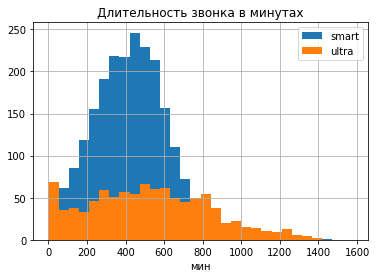

In [29]:
# Построим гистограмму по звонкам по тарифам smart и ultra:
data[data['tariff'] == 'smart']['duration'].hist(bins=30, range=(0, 1578), label='smart')
data[data['tariff'] == 'ultra']['duration'].hist(bins=30, range=(0, 1578), label='ultra')
plt.title('Длительность звонка в минутах')
plt.xlabel('мин')
plt.legend()
plt.show();

Среднее и медианное значения очень близки на обоих тарифах.
Стандартное отклонение на тарифе ultra больше, значит длительность звонков на тарифе ultra выше, чем на smart.

На гистограмме также видно, что распределение на тарифе ultra гораздо больше, значит длительность звонков у них выше относительнго среднего значения.

In [30]:
# Посчитаем среднее количество, дисперсию и стандартное отклонение по смс:
data.groupby('tariff').agg({'id': ['mean', 'median', 'std', 'var']})

id                               
             mean median        std          var
tariff                                          
smart   33.384029   28.0  28.227876   796.812958
ultra   49.363452   38.0  47.804457  2285.266143

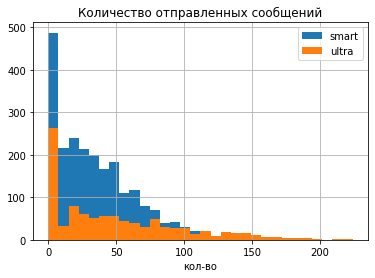

In [31]:
#Построим гистограмму по смс по тарифам smart и ultra:
data[data['tariff'] == 'smart']['id'].hist(bins=30, range=(0, 224), label='smart')
data[data['tariff'] == 'ultra']['id'].hist(bins=30, range=(0, 224), label='ultra')
plt.title('Количество отправленных сообщений')
plt.xlabel('кол-во')
plt.legend()
plt.show();

Среднее и медианное значения рознятся, особенно на трифе ultra, значит в данных много выбросов.
Стандартное отклонение на обоих тарифах велико, но на ultra все-таки выше. Это значит, что клиенты ultra отправляют большее количество сообщений. 

На гистограмме видно, что большиство клиентов не пользуется услугой отправки смс. Распределение больше на тарифе ultra, значит они отправляют большее количество сообщений относительно среднего значения.

In [32]:
# Посчитаем среднее количество, дисперсию и стандартное отклонение по интернет-трафику:
data.groupby('tariff').agg({'mb_used': ['mean', 'median', 'std', 'var']})

mb_used                                      
                mean    median           std           var
tariff                                                    
smart   16208.386990  16506.84   5870.476681  3.446250e+07
ultra   19468.805208  19308.01  10087.170752  1.017510e+08

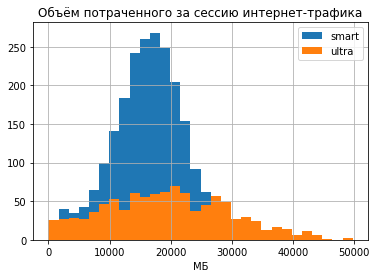

In [33]:
#Построим гистограмму по интернет-трафику по тарифам smart и ultra:
data[data['tariff'] == 'smart']['mb_used'].hist(bins=30, range=(0, 49750), label='smart')
data[data['tariff'] == 'ultra']['mb_used'].hist(bins=30, range=(0, 49750), label='ultra')
plt.title('Объём потраченного за сессию интернет-трафика')
plt.xlabel('МБ')
plt.legend()
plt.show();

Среднее и медианное значения на обоих тарифах очень близки, значит данные не имеют выбросов. Средний объём потраченного за сессию интернет-трафика выше в тарифе ultra. Стандартное отклонение на тарифе ultra выше, значит его клиенты используют больше трафика относительно среднего.

При этом мы видим, что среднее значение трафика клиентов тарифа smart выше предоставленного лимита в рамках пакета услуг. Значит они не укладываются в лимит и переплачивают за сверхлимитный трафик.

На гистограмме объем интернет-трафика также распределен больше на ultra, чем на smart, значит клиенты ultra используют больше трафика относительно среднего значения.

In [34]:
# Посчитаем среднее количество, дисперсию и стандартное отклонение по ежемесячной выручке:
data.groupby('tariff').agg({'monthly_fee': ['mean', 'median', 'std', 'var']})

monthly_fee                                  
               mean median         std            var
tariff                                               
smart   1289.973531   1023  818.404367  669785.708006
ultra   2070.152284   1950  376.187114  141516.745079

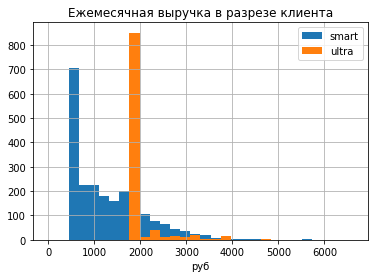

In [35]:
#Построим гистограмму по ежемесячной выручке по тарифам smart и ultra:
data[data['tariff'] == 'smart']['monthly_fee'].hist(bins=30, range=(0, 6614), label='smart')
data[data['tariff'] == 'ultra']['monthly_fee'].hist(bins=30, range=(0, 6614), label='ultra')
plt.title('Ежемесячная выручка в разрезе клиента')
plt.xlabel('руб')
plt.legend()
plt.show();

Среднее и медианное значения на тарифе smart рознятся, это значит в данных много выбросов. 
Стандартное отклонение в тарифе smart гораздо выше, что означает, что его клиенты платят больше относительно среднего значения.

На гистограмме распределение больше у клиентов тарифа smart. Значит они платят больше относительно среднего. 
Это связано с тем, что им не хватает включенного в тариф лимита интернет-трафика и им приходится переплачивать за использование сверхлимита. 

На тарифе ultra абоненты в основном укладываются в предоставленные пакетом услуги и платят только абонентскую плату.

В целом клиенты тарифа ultra платят больше, чем smart, тк у них абоненская плата почти в 4 раза выше.

### Вывод

Клиенты тарифа ultra используют больше услуг, имеют более длительные звонки, отправлют больше смс, тратят больше интернет-трафика, но и абоненская плата у них выше.

Клиенты smart в среднем платят почти в 2 раза больше, чем предусмотрено пакетом услуг, переплачивают, главным образом, за сверхлимитный интернет, тк не укладываются в предоставленный пакетом лимит.



## Проверка гипотез

Проверим следущие гипотизы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Выберем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2,equal_var).

Нулевую гипотизу сформулируем так: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны, 
альтернативную - средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны. 

In [36]:
smart = data[data['tariff'] == 'smart']['monthly_fee']
ultra = data[data['tariff'] == 'ultra']['monthly_fee']

alpha = 0.05 

results = st.ttest_ind(smart, ultra) 

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.4229814360764067e-160
Отвергаем нулевую гипотезу


Тк нулевую гипотезу мы отвергаем, значит средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны. 


Проверим вторую гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевую гипотизу сформулируем так: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов, альтернативную - средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов. 



In [37]:
moscow = data[data['city'] == 'Москва']['monthly_fee']
no_moscow = data[data['city'] != 'Москва']['monthly_fee']

alpha = 0.05 

results = st.ttest_ind(moscow, no_moscow) 

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


In [38]:
data[data['city'] == 'Москва']['monthly_fee'].mean()

1546.7135842880523

In [39]:
data[data['city'] != 'Москва']['monthly_fee'].mean()

1524.9362274298885

Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно почти 50%,
Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.

Среднее значение также говорит нам о том, что разница между московскими клиентами и региональными очень незначительна.

### Вывод

Статистический тест показал, что средняя выручка по тарифам smart и ultra различаются, а средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

## Общий вывод



В данной работе мы проверили 2 гипотезы, первая относительно доходности в части двух тарифов, вторая относительно доходности пользователей из столицы и регионов. 

Первая гипотеза подтвердила, что разница в выручке между тарифами есть. Более дорогостоящим тарифом является 'ultra", его средний чек составляет 2070 руб, что на 59% больше, чем в тарифе "smart". Стоит отметить, что клиенты тарифа "ultra" пользуются бОльшим количеством услуг, нежели клиенты "smart" (длительность звонков больше на 26%, интернет-трафик на 20%), но при этом, как мы отметили выше, платят они на 59% больше. Поэтому данный тариф бесспорно выгоднее для компании.

Вторая гипотеза показала, что выручка от жителей столицы не отличается от жителей регионов. Средний чек жителей столицы всего на 1.4% больше чека жителей регионов, это значит, что в не зависимости от общего дохода, траты на связь и интернет одинаковы для крупных городов страны.
